## Problem Statement

Since the dawn of the 2 party system, Liberals and Conservaties have been at the center of the political scene. As we've seen in recent years, the ideals of both sides couldn't be more diametrically opposed. As such, if we pull the data from posts from the respective subreddits, we should be able to easily classify which post belongs to which subreddit. 

When fed these posts, can Python predict which subreddit each post belongs to based solely on NLP and word vectorization?

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier

## Data Cleaning and EDA 
Here I begin some exploration and additional cleaning after the major steps of the initial gathering are completed. You will be able to import the concatenated dataframe of both subreddits being used starting in the cell below. 

In [2]:
df = pd.read_csv('./data/subreddit_complete.csv')

In [3]:
# I ran into a problem while modeling below and have to rename my subreddit variable
df.rename(columns={'subreddit': 'sub'}, inplace=True)
df.columns

Index(['Unnamed: 0', 'sub', 'title', 'author', 'domain', 'id', 'num_comments',
       'score', 'selftext', 'url', 'title_word_count', 'sentiment'],
      dtype='object')

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
df[['title', 'title_word_count']].head()

,title,title_word_count
0,"On behalf of my neanderthal ancestors, I object!",8
1,You Can't Change This Hatred—You Have to Outnumber It,9
2,Black teen fails all but 3 classes in 4 years of high school. Ranks near top half of class with a 0.13 GPA.,23
3,How The Press Enables The GOP’s Big Lie,8
4,Russian State TV Is Really Missing Trump Now Biden’s Sanctions Hit,11


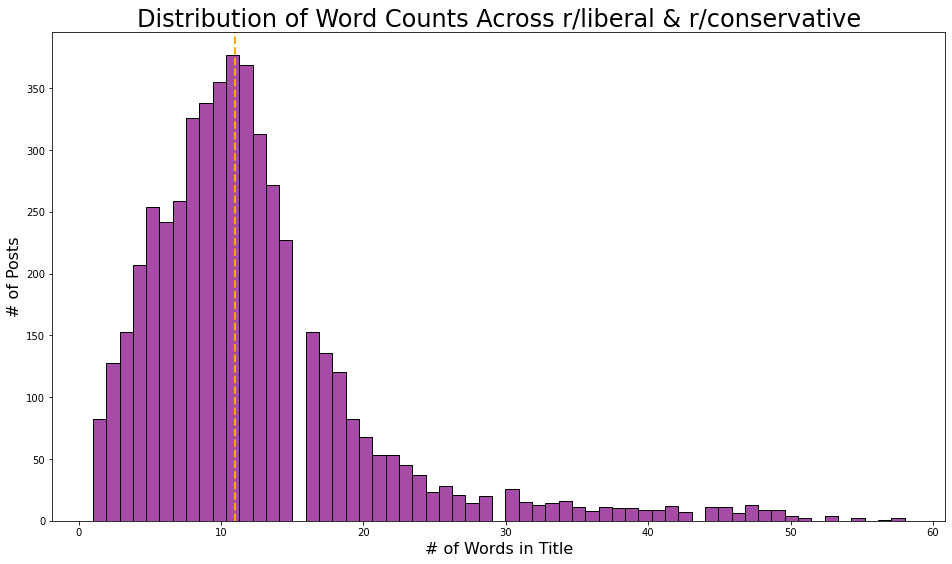

In [6]:
plt.figure(figsize=(16,9))
sns.histplot(df['title_word_count'], color='purple', alpha=0.7)
plt.axvline(x=df['title_word_count'].median(), linewidth=2, linestyle='--', color='orange')
plt.xlabel('# of Words in Title', size=16)
plt.ylabel('# of Posts', size=16)
plt.title('Distribution of Word Counts Across r/liberal & r/conservative', size=24);

In [7]:
# Repost Alert!
duplicated = df[df[['url']].duplicated(keep='first')]
duplicated['sub'].value_counts(normalize=True)

0    0.648936
1    0.351064
Name: sub, dtype: float64

In [8]:
unique_users = df[df.columns].drop_duplicates('author')
unique_users.shape

(2216, 12)

In [9]:
print(f"The percentage of unique users to the total population of users of both subreddits is: {(len(unique_users['author']) / len(df['author'])) * 100}%")

The percentage of unique users to the total population of users of both subreddits is: 44.32%


# Explain some of your findings from above here.

In [10]:
# Inspiration from: https://medium.com/bigpanda-engineering/exploratory-data-analysis-for-text-data-29cf7dd54eb8
cvec = CountVectorizer(stop_words='english')
counts = cvec.fit_transform(df['title'])
pd.DataFrame(counts.sum(axis=0), columns=cvec.get_feature_names()).T.sort_values(0, ascending=False).head(25)

,0
trump,742
biden,633
covid,210
election,199
capitol,180
new,166
says,164
white,154
house,151
joe,146


In [11]:
from wordcloud import WordCloud

In [12]:
cvec_ngram = CountVectorizer(ngram_range=(2,2), stop_words='english')
counts_ngram = cvec_ngram.fit_transform(df.title)
pd.DataFrame(counts_ngram.sum(axis=0), columns=cvec_ngram.get_feature_names()).T.sort_values(0, ascending=False).head(25)

,0
joe biden,122
covid 19,86
donald trump,78
dr seuss,72
white house,69
cancel culture,36
capitol riot,35
mask mandate,32
trump supporters,32
andrew cuomo,29


In [13]:
# https://stackoverflow.com/a/49661812
author = pd.DataFrame(df['author'].value_counts().reset_index().values, columns=['author', 'number_of_posts']).head(26)
author.drop(labels=0, axis=0, inplace=True) # Drop [deleted] users' posts
author.reset_index(drop=True, inplace=True)
author

,author,number_of_posts
0,SpaceRocker420,250
1,Walk1000Miles,112
2,Havvocck2,88
3,canfbar,82
4,Winterhold2000,79
5,guanaco55,76
6,nimobo,69
7,spaceghoti,60
8,Foubar_ghost,56
9,f1sh98,54


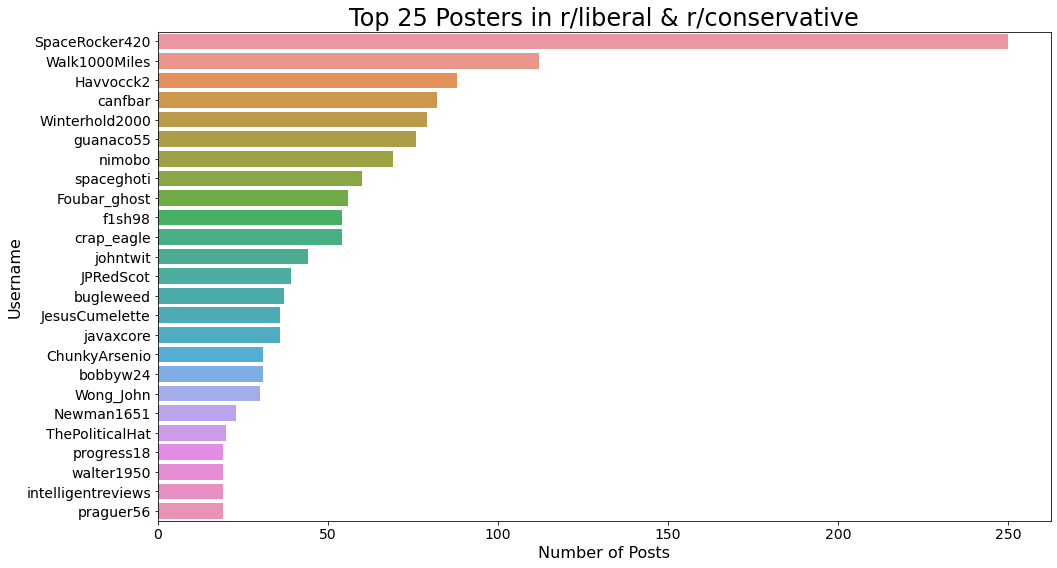

In [14]:
plt.figure(figsize=(16,9))
sns.barplot(y=author['author'], x=author['number_of_posts'])
plt.xlabel('Number of Posts', size=16)
plt.ylabel('Username', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Top 25 Posters in r/liberal & r/conservative', size=24);


In [15]:
counts = pd.DataFrame(counts.todense(), columns=cvec.get_feature_names())

In [16]:
# Dropping the subreddit column from the count vectorized dataframe
counts.drop(columns=['sub'], inplace=True)

In [17]:
df_vec = pd.concat([df, counts], axis=1)
df_vec.head(1)

,Unnamed: 0,sub,title,author,domain,id,num_comments,score,selftext,url,...,накануне,нефть,отыгрывая,перешла,российской,росту,снижение,спутник,стремительному,успеть
0,0,1,"On behalf of my neanderthal ancestors, I object!",MisanthropicScott,self.Liberal,ly2nha,0,1,[removed],https://www.reddit.com/r/Liberal/comments/ly2nha/on_behalf_of_my_neanderthal_ancestors_i_object/,...,0,0,0,0,0,0,0,0,0,0


In [18]:
X = df['title']
y = df['sub']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify=y)

In [19]:
# Baseline Accuracy
y_test.value_counts(normalize=True)

0    0.5
1    0.5
Name: sub, dtype: float64

## Logistic Regression

In [20]:
lr_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

lr_params = {
    'cv__ngram_range': [(1,1), (1,2), (2,2)]
}

In [21]:
lr_gs = GridSearchCV(lr_pipe,
                     param_grid=lr_params,
                    cv=10)

lr_gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('lr', LogisticRegression())]),
             param_grid={'cv__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [22]:
print(lr_gs.score(X_train, y_train))
print(lr_gs.score(X_test, y_test))

0.9883582089552239
0.7242424242424242


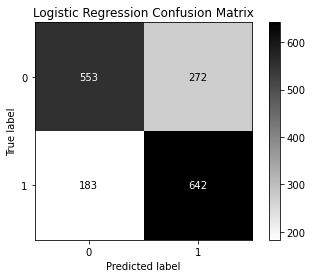

In [23]:
plot_confusion_matrix(lr_gs, X_test, y_test, cmap='binary')
plt.title('Logistic Regression Confusion Matrix');

## Count Vectorizer & Bernoulli Naive Bayes

Beyond simple logistic regression, the first model I attempted to fit is the Bernoulli model with a count vectorizer in a pipeline. With no parameter tuning, the model performed reasonably well, with a testing accuracy of 71%  as a start before parameter tuning. 

At first, parameter tuning was a trial and error process. I plugged in parameters based on our lessons on the models, and I started to tweak those parameters further as I got more results, until the scores levelled out. However, parameter tuning ultimately did not improve my accuracy scores beyond my initial modeling.

Custom stopwords were attempted based on high frequency of appearance in the EDA process, however, the selected words only served to make my model worse, so they were ultimately not used.

### Count Vectorizer & BNB Classifier

In [24]:
# stops = ['left', 'president', 'america', 'trump', 'capitol', 'black', 'white', 'people', 'time', 'biden', 'house', 'want', 'new', 'just', 'covid', 'gop', 'conservative', 'says', 'democrats', 'joe', 'video', 'police', 'senate', 'election']

In [25]:
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('bnb', BernoulliNB())
])

In [26]:
pipe_params = {
    'cv__max_features': [4000],
    'cv__min_df': [2],
    'cv__max_df': [0.9],
    'cv__ngram_range': [(1,2)]
}

In [27]:
gs = GridSearchCV(pipe,
                 pipe_params,
                 cv=10)

In [28]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cv__max_df': [0.9], 'cv__max_features': [4000],
                         'cv__min_df': [2], 'cv__ngram_range': [(1, 2)]})

In [29]:
# print(gs.best_score_)
gs.best_params_

{'cv__max_df': 0.9,
 'cv__max_features': 4000,
 'cv__min_df': 2,
 'cv__ngram_range': (1, 2)}

In [30]:
# print(gs.score(X_train, y_train))
# print(gs.score(X_test, y_test))
model = gs.best_estimator_

In [31]:
mnb_preds = gs.predict(X_test)

In [32]:
model.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.9, max_features=4000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('bnb', BernoulliNB())])

In [33]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.8340298507462687
0.7115151515151515


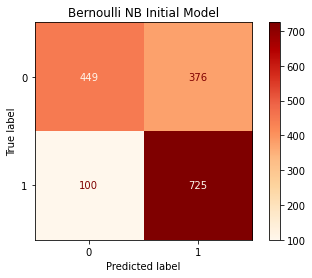

In [34]:
plot_confusion_matrix(model, X_test, y_test, cmap='OrRd', values_format='d')
plt.title('Bernoulli NB Initial Model');

### BNB Parameter Tuning

In [35]:
pipe_params_2 = {
    'cv__max_features': [4000],
    'cv__min_df': [2],
    'cv__max_df': [0.95],
    'cv__ngram_range': [(1,2)],    
}

In [36]:
gs_2 = GridSearchCV(pipe,
                   pipe_params_2,
                   cv=5,
                   n_jobs=5)

In [37]:
gs_2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words='english')),
                                       ('bnb', BernoulliNB())]),
             n_jobs=5,
             param_grid={'cv__max_df': [0.95], 'cv__max_features': [4000],
                         'cv__min_df': [2], 'cv__ngram_range': [(1, 2)]})

In [38]:
# print(gs.best_params_)
print(gs_2.best_params_)

{'cv__max_df': 0.95, 'cv__max_features': 4000, 'cv__min_df': 2, 'cv__ngram_range': (1, 2)}


In [39]:
print(gs_2.score(X_train, y_train))
print(gs_2.score(X_test, y_test))

0.8340298507462687
0.7115151515151515


In [40]:
gs_2.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.95, max_features=4000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('bnb', BernoulliNB())])

In [41]:
best_pipe_bnb = gs_2.best_estimator_

In [42]:
best_pipe_bnb.fit(X_train, y_train)

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.95, max_features=4000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('bnb', BernoulliNB())])

In [43]:
print(best_pipe_bnb.score(X_train, y_train))
print(best_pipe_bnb.score(X_test, y_test))

0.8340298507462687
0.7115151515151515


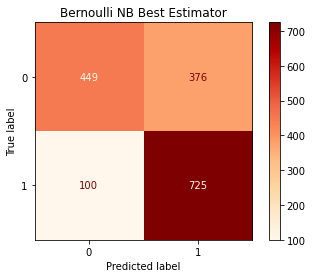

In [44]:
plot_confusion_matrix(best_pipe_bnb, X_test, y_test, cmap='OrRd')
plt.title('Bernoulli NB Best Estimator');

## TFIDF & Bernoulli Naive Bayes

I decided to keep going with the Naive Bayes model, but instead using TFIDF instead of a count vectorizer. Ultimately, this turned out being the best model after parameter tuning. Once again, I started with parameters pulled from our in class lessons to determine a starting point, then began tinkering with parameters again until my scores levelled out. 

As I was tuning parameters, I kept shifting around the best ones while removing those that changed, so as to keep processing time and power as minimal as possible. 

The model performed better at classifying the True Positive (predicting r/liberal in this case) than it did the alternative, perhaps because the posts in r/liberal tend to be overall wordier than in r/conservative. 

### TFIDF/BNB Classifier

In [45]:
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [46]:
tfidf_pipe_params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1,1), (1,2), (2,2)]
}

In [47]:
tfidf_gs = GridSearchCV(tfidf_pipe,
                   tfidf_pipe_params,
                   cv=10,
                   n_jobs=4)

In [48]:
tfidf_gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=4,
             param_grid={'tfidf__max_features': [2000, 3000, 4000, 5000],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tfidf__stop_words': [None, 'english']})

In [49]:
# print(tfidf_gs.best_score_)
# print(tfidf_gs.best_params_)
tfidf_model = tfidf_gs.best_estimator_

In [50]:
tfidf_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
                ('bnb', BernoulliNB())])

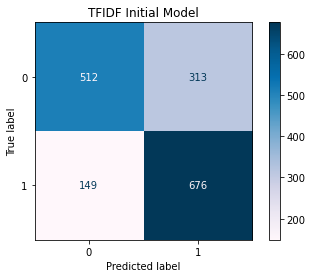

In [51]:
plot_confusion_matrix(tfidf_model, X_test, y_test, cmap='PuBu', values_format='d')
plt.title('TFIDF Initial Model');

### TFIDF Parameter Tuning

In [52]:
# Edited for best estimator for speed of fitting in the future
# {'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
tfidf_params_2 = {
    'tfidf__max_features': [6500],
    'tfidf__ngram_range': [(1,1)],
    'tfidf__stop_words': [None]
}

In [53]:
tfidf_gs_2 = GridSearchCV(tfidf_pipe,
             tfidf_params_2,
             cv=10,
             n_jobs=5)

tfidf_gs_2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             n_jobs=5,
             param_grid={'tfidf__max_features': [6500],
                         'tfidf__ngram_range': [(1, 1)],
                         'tfidf__stop_words': [None]})

In [54]:
print(f'Original fitting best parameters: {tfidf_gs.best_params_}')
print(f'Best parameters after tuning: {tfidf_gs_2.best_params_}')

Original fitting best parameters: {'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Best parameters after tuning: {'tfidf__max_features': 6500, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}


In [55]:
best_pipe_tfidf = tfidf_gs_2.best_estimator_
best_pipe_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=6500)),
                ('bnb', BernoulliNB())])

In [56]:
print(f'Original fit train score: {tfidf_gs.score(X_train, y_train)}')
print(f'Original fit test score: {tfidf_gs.score(X_test, y_test)}')
print(f'Best estimator train score: {best_pipe_tfidf.score(X_train, y_train)}')
print(f'Best estimator test score: {best_pipe_tfidf.score(X_test, y_test)}')

Original fit train score: 0.8176119402985075
Original fit test score: 0.72
Best estimator train score: 0.8814925373134328
Best estimator test score: 0.7254545454545455


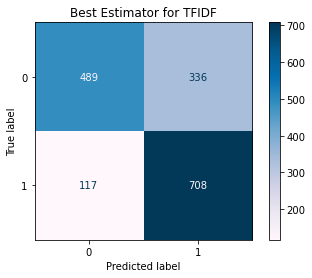

In [57]:
plot_confusion_matrix(best_pipe_tfidf, X_test, y_test, cmap='PuBu')
plt.title('Best Estimator for TFIDF');

## Random Forests

The final set of models tested, and the only one required to appear in the project, performed incredibly well on the training data, but subsequently failed to accurately predict on the unseen testing data. The accuracy score near of over 0.99 on the training data from both the basic model and the parameter tuned model, leads me to believe they were overfit on the training data leading to poor performance on new data.

Once again, I started with parameters similar to those introduced in class and worked through the tuning until the accuracy scores levelled out, removing unused parameters along the way. 

### Random Forest Modeling

In [58]:
rf_pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [59]:
# Edited with best parameters for speed of future fitting
rf_params = {
    'cv__stop_words': [None],
    'cv__ngram_range': [(1,1)],
    'rf__n_estimators': [100],
    'rf__max_depth': [None]
}

In [60]:
rf_gs = GridSearchCV(rf_pipe,
                    rf_params,
                    cv=10,
                    n_jobs=5)

In [61]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'cv__ngram_range': [(1, 1)], 'cv__stop_words': [None],
                         'rf__max_depth': [None], 'rf__n_estimators': [100]})

In [62]:
print(rf_gs.best_params_)
print(rf_gs.best_estimator_)

{'cv__ngram_range': (1, 1), 'cv__stop_words': None, 'rf__max_depth': None, 'rf__n_estimators': 100}
Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])


In [63]:
rf_model = rf_gs.best_estimator_

In [64]:
print(rf_model.score(X_train, y_train))
print(rf_model.score(X_test, y_test))

0.9982089552238806
0.7212121212121212


In [65]:
rf_preds = rf_model.predict(X_test)

In [66]:
confusion_matrix(rf_preds, y_test)

array([[505, 140],
       [320, 685]])

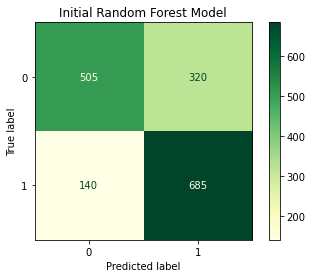

In [67]:
plot_confusion_matrix(rf_model, X_test, y_test, cmap='YlGn')
plt.title('Initial Random Forest Model');

### Random Forest Parameter Tuning

In [68]:
# Edited for best parameters for future speed of fit.
# {'cv__ngram_range': (1, 1), 'cv__stop_words': 'english', 'rf__max_depth': None, 'rf__n_estimators': 200}
rf_params_2 = {
    'cv__stop_words': ['english'],
    'cv__ngram_range': [(1,1)],
    'rf__n_estimators': [200],
    'rf__max_depth': [None]
}

rf_gs_2 = GridSearchCV(rf_pipe,
                      rf_params_2,
                      cv=10,
                      n_jobs=5)

rf_gs_2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=5,
             param_grid={'cv__ngram_range': [(1, 1)],
                         'cv__stop_words': ['english'], 'rf__max_depth': [None],
                         'rf__n_estimators': [200]})

In [69]:
rf_gs_2.best_estimator_

Pipeline(steps=[('cv', CountVectorizer(stop_words='english')),
                ('rf', RandomForestClassifier(n_estimators=200))])

In [70]:
print(rf_gs_2.best_params_)
print(rf_gs_2.score(X_train, y_train))
print(rf_gs_2.score(X_test, y_test))

{'cv__ngram_range': (1, 1), 'cv__stop_words': 'english', 'rf__max_depth': None, 'rf__n_estimators': 200}
0.9976119402985074
0.7048484848484848


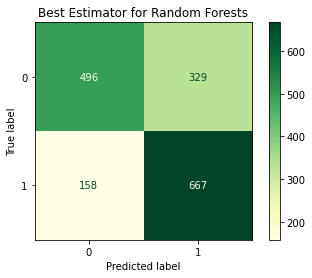

In [71]:
plot_confusion_matrix(rf_gs_2, X_test, y_test, cmap='YlGn')
plt.title('Best Estimator for Random Forests');

## Sentiment Analysis Addition

I wanted to work with some sentiment analysis to try improving my models, but unfortunately was unable to tailor any modeling due to constraints on time. I do hope to use the base I've built here to come back and explore the data further and potentially better classify the target subreddits.

In [72]:
from transformers import pipeline
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [73]:
sent = pipeline('sentiment-analysis')
nltk = SentimentIntensityAnalyzer()

In [74]:
# Sentiment dataframe saved below
# df['sentiment'] = [sent(i) for i in df['title']]
# df['nltk_sentiment'] = [nltk.polarity_scores(i) for i in df['title']]

In [75]:
# sent_df = df[['sub', 'title', 'score', 'sentiment', 'nltk_sentiment']]

In [76]:
# sent_df.to_csv('./data/sentiment.csv')
sent_df = pd.read_csv('./data/sentiment.csv')
sent_df.head(1)

,Unnamed: 0,sub,title,score,sentiment,nltk_sentiment
0,0,1,"On behalf of my neanderthal ancestors, I object!",1,"[{'label': 'POSITIVE', 'score': 0.9767237901687622}]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


In [77]:
# source: https://www.tutorialspoint.com/convert-a-string-representation-of-list-into-list-in-python
# sent_df['sentiment'] = [row.strip('][').split(', ') for row in sent_df['sentiment']]

In [78]:
sent_df['sentiment'][0]

"[{'label': 'POSITIVE', 'score': 0.9767237901687622}]"

In [79]:
sent_df['sentiment'] = [row.replace('[', '').replace(']', '').replace('"', '') for row in sent_df['sentiment']]

In [80]:
# source https://stackoverflow.com/a/29713010
sent_df['sentiment'] = [eval(row) for row in sent_df['sentiment']]

In [81]:
print(type(sent_df['sentiment'][0]))
sent_df['sentiment'][0]

<class 'dict'>


{'label': 'POSITIVE', 'score': 0.9767237901687622}

In [82]:
type(sent_df['sentiment'][0]['score'])
sent_df['sentiment'][0]['label']

'POSITIVE'

In [83]:
sent_df['bert_sentiment'] = sent_df['sentiment'].apply(lambda x: x['score'] * 1 if x['label'] == 'POSITIVE' else x['score'] * -1)
sent_df['bert_sentiment']

0       0.976724
1      -0.991927
2      -0.982755
3       0.987696
4      -0.999180
          ...   
4995   -0.947833
4996   -0.866881
4997   -0.984415
4998   -0.998453
4999   -0.999736
Name: bert_sentiment, Length: 5000, dtype: float64

In [84]:
sent_df.head(1)

,Unnamed: 0,sub,title,score,sentiment,nltk_sentiment,bert_sentiment
0,0,1,"On behalf of my neanderthal ancestors, I object!",1,"{'label': 'POSITIVE', 'score': 0.9767237901687622}","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",0.976724


<AxesSubplot:xlabel='score', ylabel='bert_sentiment'>

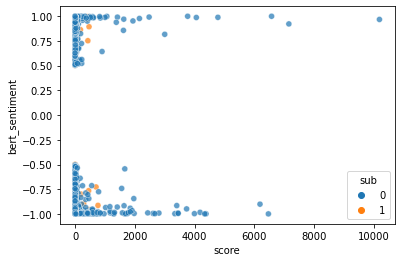

In [85]:
sns.scatterplot(data=sent_df,
                x=sent_df['score'],
                y=sent_df['bert_sentiment'],
               hue=sent_df['sub'],
               alpha=0.7)

## Conclusions

I sought to identify whether a post would be correctly classified through NLP, which I thought should be easy based on the language used and the ideals held by both political affiliations. Instead, I proved that both sides may be more similar to one another than either would care to admit. Python struggled to accurately differentiate the posts when fed into various models, never achieving an accuracy score on the testing set of data in an acceptable range. It is possible that the models were not fed enough parameters during tuning to effectively whittle down the inherent errors, and I will seek to further optimize these models in future iterations.